In [1]:
import pandas as pd
import sqlite3
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter("ignore")

# Load Solar Production Data from SQLite Database

In [18]:
conn = sqlite3.connect('solar.db')
cur = conn.cursor()
q = "SELECT * FROM production"
df = pd.read_sql_query(q, conn)
q = "SELECT * FROM rec"
df_rec = pd.read_sql_query(q, conn)
#conn.commit()
conn.close()

In [19]:
df['month'] = df.date.apply(lambda date: date.split('/')[0])
df['day'] = df.date.apply(lambda date: date.split('/')[1])
df['year'] = df.date.apply(lambda date: date.split('/')[2])

In [20]:
df.head()

,date,energy_Wh,month,day,year
0,10/10/2015,0,10,10,2015
1,10/11/2015,0,10,11,2015
2,10/12/2015,0,10,12,2015
3,10/13/2015,0,10,13,2015
4,10/14/2015,0,10,14,2015


# Annual Energy Production per Month

In [21]:
Wh = np.empty((6,12))*np.nan
years = range(2015, 2020)
months = range(1,13)
for y_idx in range(0, len(years)):
    for m_idx in range(0, len(months)):
        Wh[y_idx, m_idx] = df[(df.month == str(months[m_idx])) & (df.year == str(years[y_idx]))].sum().energy_Wh / 1000.0

In [22]:
Wh[0,0:10] = np.nan  # Special case for Months 1-10 of 2015
Wh[-2,-1] = np.nan  # Special case for months in the future of this year
print(Wh)

[[     nan      nan      nan      nan      nan      nan      nan      nan
       nan      nan  579.691  539.781]
 [ 790.595  845.73  1126.713 1291.764 1214.082 1451.075 1394.291 1408.287
  1120.86  1014.415  777.081  758.292]
 [ 721.933  753.706 1012.772 1125.741 1068.762 1287.859 1307.34  1359.23
  1128.301  991.193  812.052  570.402]
 [ 691.655  739.723  932.431 1101.9   1373.786 1269.668 1501.164 1262.764
   928.478  772.904  570.763  858.664]
 [ 766.201  881.772 1225.508  587.538 1142.567 1274.722 1476.597 1461.286
  1299.691  763.94   817.557      nan]
 [     nan      nan      nan      nan      nan      nan      nan      nan
       nan      nan      nan      nan]]


In [23]:
median_energy = np.empty((12))*np.nan
upper_energy  = np.empty((12))*np.nan
lower_energy  = np.empty((12))*np.nan
energy_stddev = np.empty((12))*np.nan
for m_idx in range(0, len(months)):
    median_energy[m_idx] = np.nanmedian(Wh[:, m_idx])  # only done for complete years,
    energy_stddev[m_idx] = np.nanstd(Wh[:, m_idx])
    upper_energy[m_idx] = median_energy[m_idx] + energy_stddev[m_idx]
    lower_energy[m_idx] = median_energy[m_idx] - energy_stddev[m_idx]

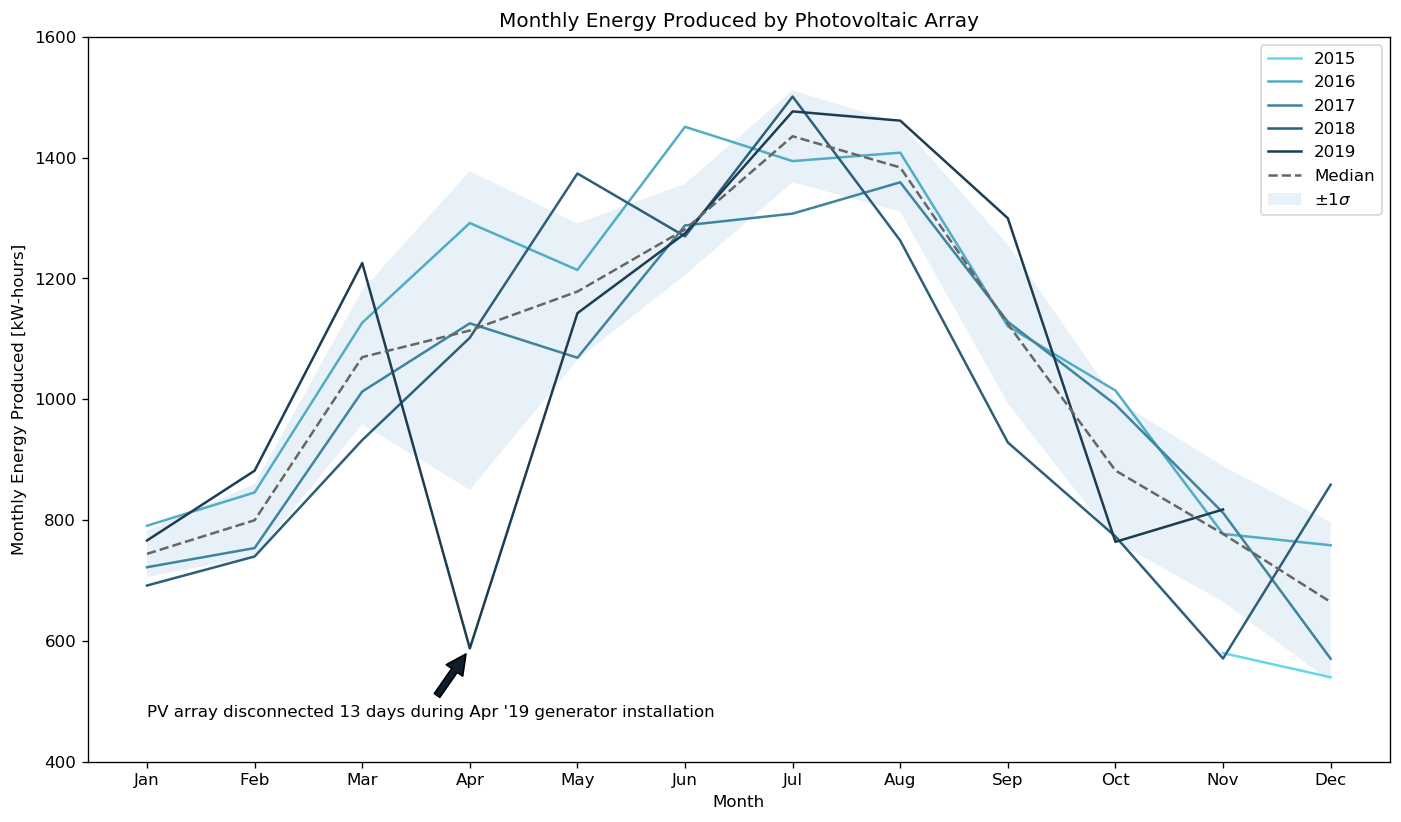

In [24]:
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')

plot_labels = ['2015', '2016', '2017', '2018', '2019', '2020']
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]

plt.fill_between(months,lower_energy, upper_energy, alpha=0.1, label=r"$\pm$1$\sigma$" )
plt.plot(months, Wh[0, :], '-', label=plot_labels[0], color=blues[0])
plt.plot(months, Wh[1, :], '-', label=plot_labels[1], color=blues[1])
plt.plot(months, Wh[2, :], '-', label=plot_labels[2], color=blues[2])
plt.plot(months, Wh[3, :], '-', label=plot_labels[3], color=blues[3])
plt.plot(months, Wh[4, :], '-', label=plot_labels[4], color=blues[4])
#plt.plot(months, Wh[5, :], '-', label=plot_labels[5], color=blues[5])
plt.plot(months, median_energy, '--', label="Median", color="#666666")

plt.ylim((400, 1600))
plt.legend(loc='upper right')
plt.title('Monthly Energy Produced by Photovoltaic Array')
plt.xlabel('Month')
plt.ylabel('Monthly Energy Produced [kW-hours]')
ax = plt.subplot()
ax.set_xticks(months)
ax.set_xticklabels(month_labels)
ax.annotate("PV array disconnected 13 days during Apr '19 generator installation", xy=(4, 587.5), xytext=(1,475), arrowprops=dict(facecolor=blues[5], shrink=0.1))
plt.show()

# Analyzing Daily Production per Month
Not accounting for anomalous days with zero production (e.g. power outages or days with the array disconnected, this analysis evaluates daily production per month.

In [25]:
daily_median = np.zeros((12,1))*np.nan
daily_std = np.zeros((12,1))*np.nan
daily_min = np.zeros((12,1))*np.nan
daily_max = np.zeros((12,1))*np.nan
d_upper = np.zeros((12))*np.nan
d_lower = np.zeros((12))*np.nan
months = list(range(1,13))

for m in months:
    g = df[(df.month == str(m))].energy_Wh.replace(0, np.nan)
    daily_median[m-1,0] = np.nanmedian(g)
    daily_std[m-1,0] = np.nanstd(g) 
    daily_min[m-1,0] = np.nanmin(g)
    daily_max[m-1,0] = np.nanmax(g)
    d_upper[m-1] = daily_median[m-1,0] + daily_std[m-1,0]
    d_lower[m-1] = daily_median[m-1,0] - daily_std[m-1,0]

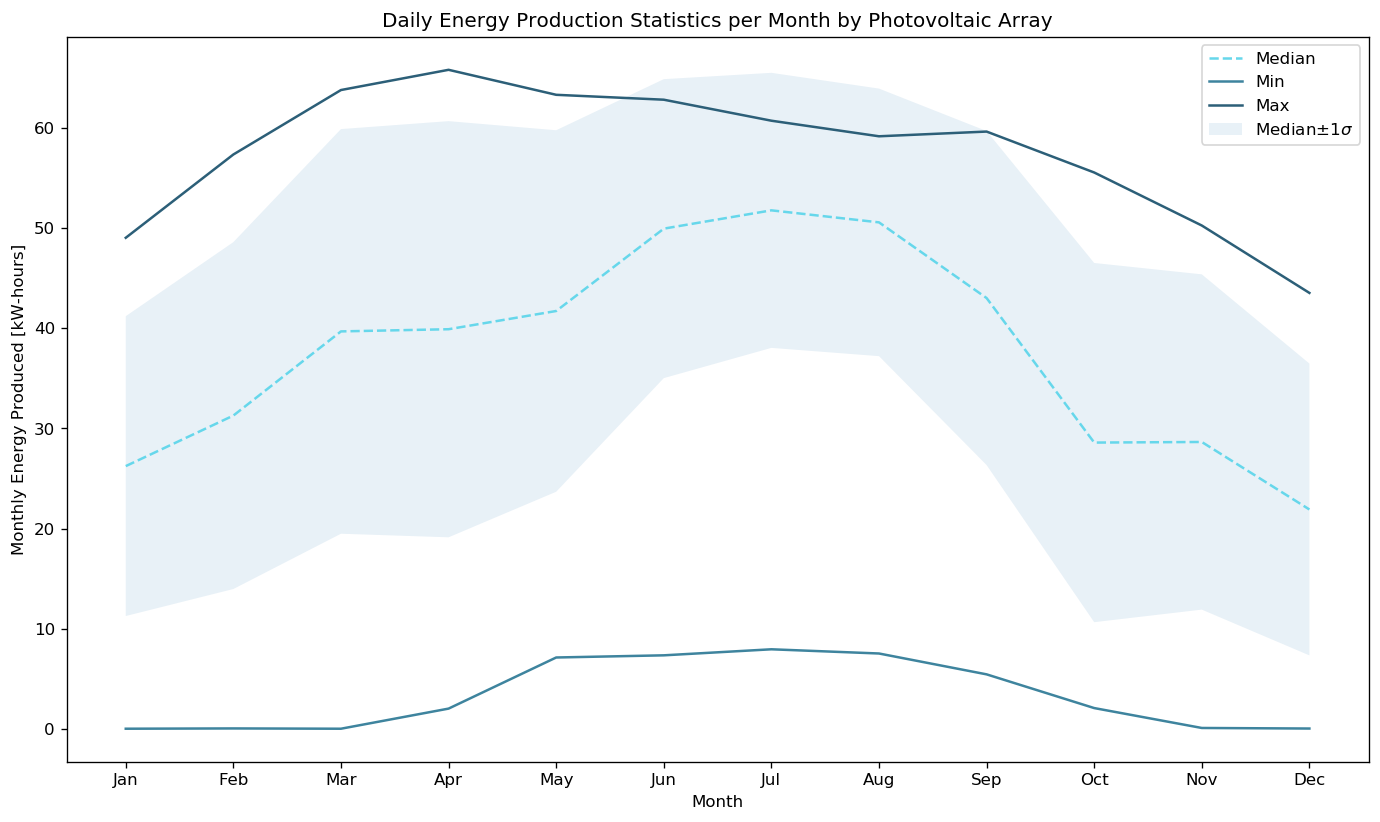

In [26]:
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
plot_labels = ["Median", r"$\pm$1$\sigma$", "Min", "Max"]

plt.fill_between(months, d_lower/ 1000.0, d_upper/ 1000.0, alpha=0.1, label=r"Median$\pm$1$\sigma$" )
plt.plot(months, daily_median/ 1000.0, '--', label=plot_labels[0], color=blues[0])
plt.plot(months, daily_min/ 1000.0, '-', label=plot_labels[2], color=blues[2])
plt.plot(months, daily_max/ 1000.0, '-', label=plot_labels[3], color=blues[3])

plt.legend(loc='upper right')
plt.title('Daily Energy Production Statistics per Month by Photovoltaic Array')
plt.xlabel('Month')
plt.ylabel('Monthly Energy Produced [kW-hours]')
ax = plt.subplot()
ax.set_xticks(months)
ax.set_xticklabels(month_labels)

plt.legend()
plt.show()

## Revenue Credit (REC) Production

In [27]:
install_date = {"month": 10, "year": 15}
df_rec["months_since_install"] = (df_rec["year"]-install_date["year"])*12 + (df_rec["month"]-install_date["month"])
df_rec.head()

,month,year,reading,date_recorded,r_mo,r_dy,r_yr,months_since_install
0,12,15,53,1/1/2016,1,1,2016,2
1,3,16,7082,4/1/2016,4,1,2016,5
2,6,16,8244,7/12/2016,7,12,2016,8
3,9,16,11689,10/4/2016,10,4,2016,11
4,10,16,12749,11/6/2016,11,6,2016,12


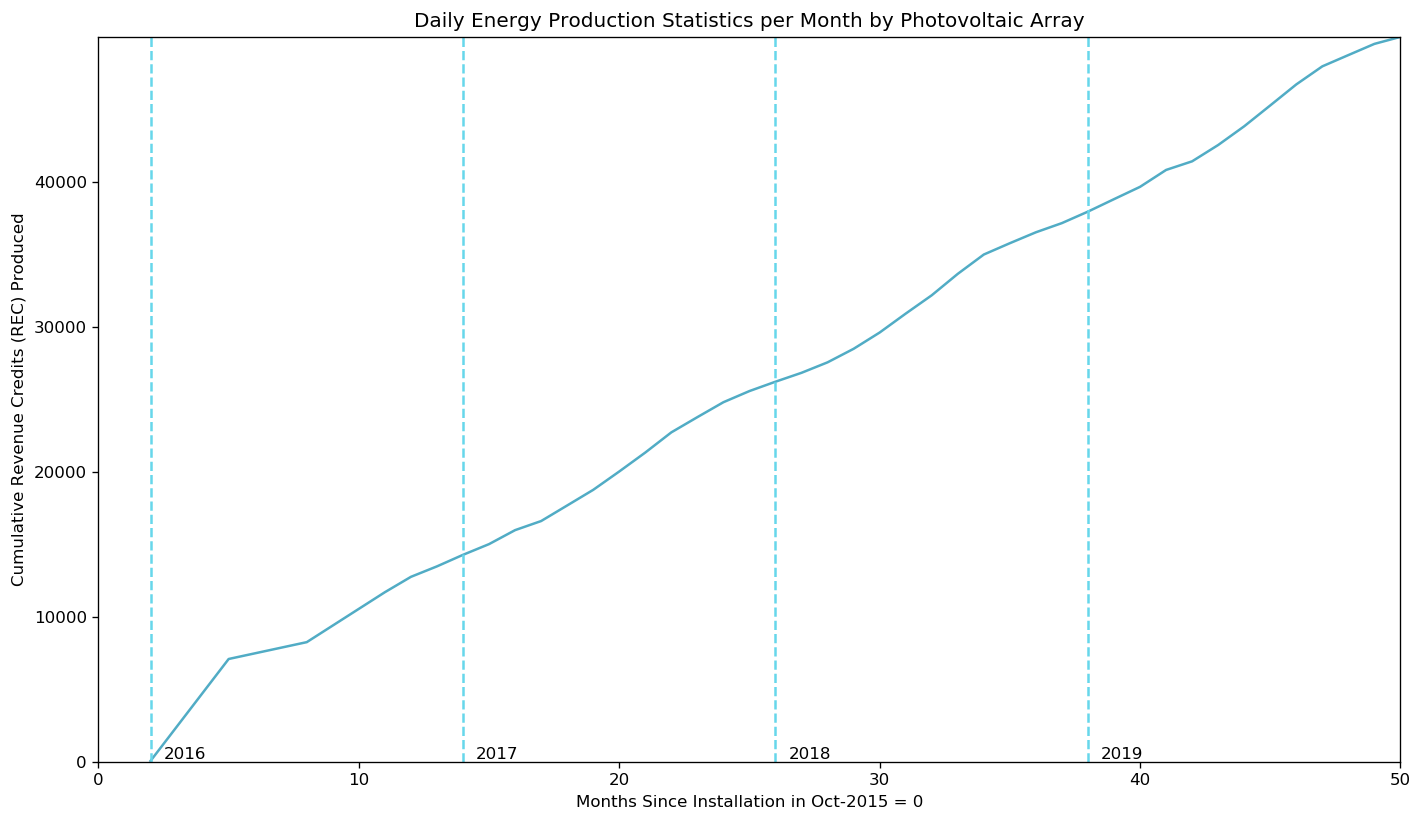

In [28]:
fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]

plt.plot(df_rec.months_since_install, df_rec.reading, color=blues[1], label="REC Production")
ax = plt.subplot()

year_annotate = 2016 # first year REC records kept
calendar_year_marker = np.zeros((int(np.floor(max(df_rec.months_since_install)/12.0))))
for idx in range(0,len(calendar_year_marker)):
    calendar_year_marker[idx] = 2 + idx*12  # draw vertical lines on January 1st calendar markers
    plt.axvline(x=calendar_year_marker[idx], linestyle='--', color=blues[0])
    ax.annotate(str(year_annotate), xy=(calendar_year_marker[idx]+0.5, 200), xytext=(calendar_year_marker[idx]+0.5,200))
    year_annotate += 1


plt.xlim((0,max(df_rec.months_since_install)))
plt.ylim((0,max(df_rec.reading)))
plt.title('Daily Energy Production Statistics per Month by Photovoltaic Array')
plt.xlabel('Months Since Installation in Oct-2015 = 0')
plt.ylabel('Cumulative Revenue Credits (REC) Produced')
plt.show()

In [29]:
#TODO fit localized sigmoid or detrended sinusoidal function

Coefficients: [-3.61265257e-03  4.54573273e-01 -1.90800107e+01  1.29810955e+03
 -1.11196642e+03]


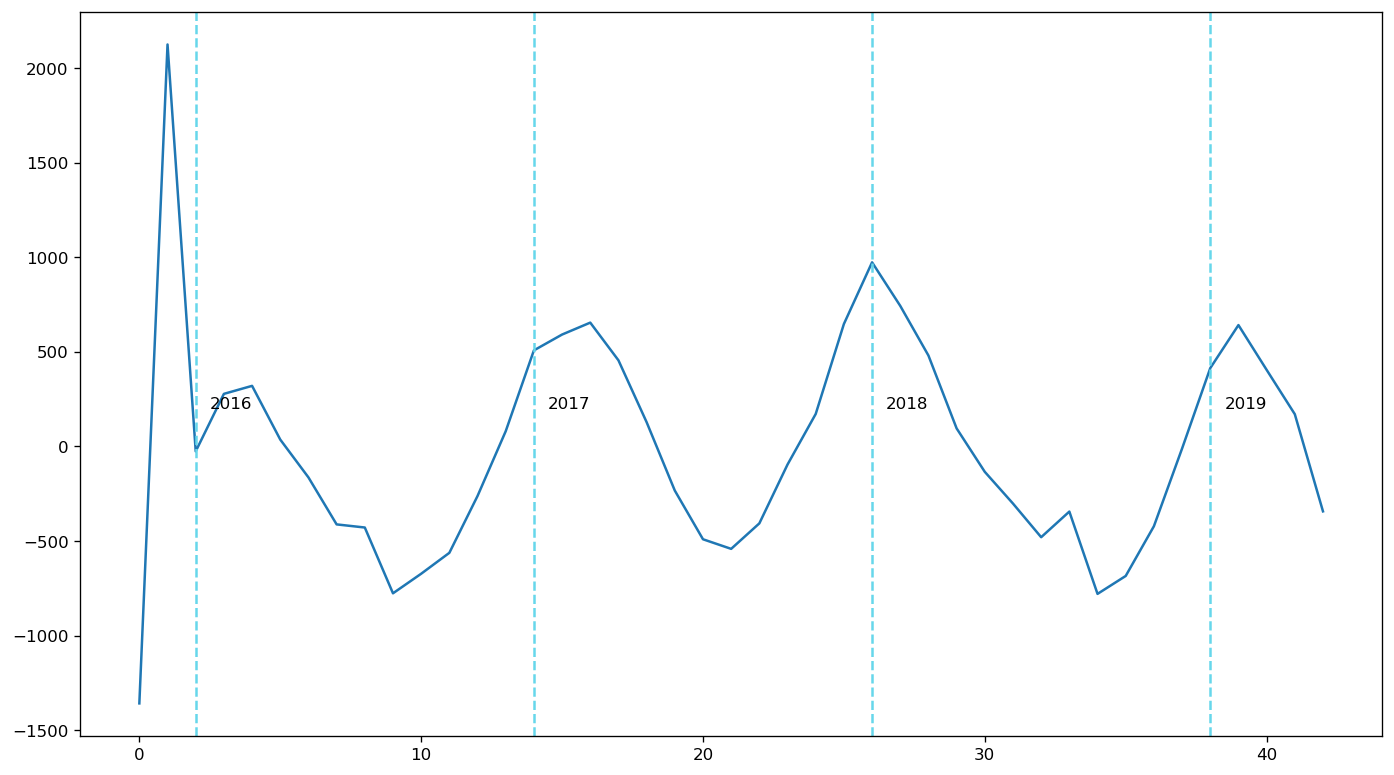

In [30]:
X = df_rec.months_since_install
X2 = np.diff(X, n=1)
y = df_rec.reading

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]
ax = plt.subplot()

degree = 4
coef = np.polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)

values = df_rec.reading
diff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)
plt.plot(diff)


year_annotate = 2016 # first year REC records kept
calendar_year_marker = np.zeros((int(np.floor(max(df_rec.months_since_install)/12.0))))
for idx in range(0,len(calendar_year_marker)):
    calendar_year_marker[idx] = 2 + idx*12  # draw vertical lines on January 1st calendar markers
    plt.axvline(x=calendar_year_marker[idx], linestyle='--', color=blues[0])
    ax.annotate(str(year_annotate), xy=(calendar_year_marker[idx]+0.5, 200), xytext=(calendar_year_marker[idx]+0.5,200))
    year_annotate += 1
    
plt.show()

   month  year  reading date_recorded  r_mo  r_dy  r_yr  months_since_install
0     12    15       53      1/1/2016     1     1  2016                     2
1      3    16     7082      4/1/2016     4     1  2016                     5
2      6    16     8244     7/12/2016     7    12  2016                     8
3      9    16    11689     10/4/2016    10     4  2016                    11
4     10    16    12749     11/6/2016    11     6  2016                    12


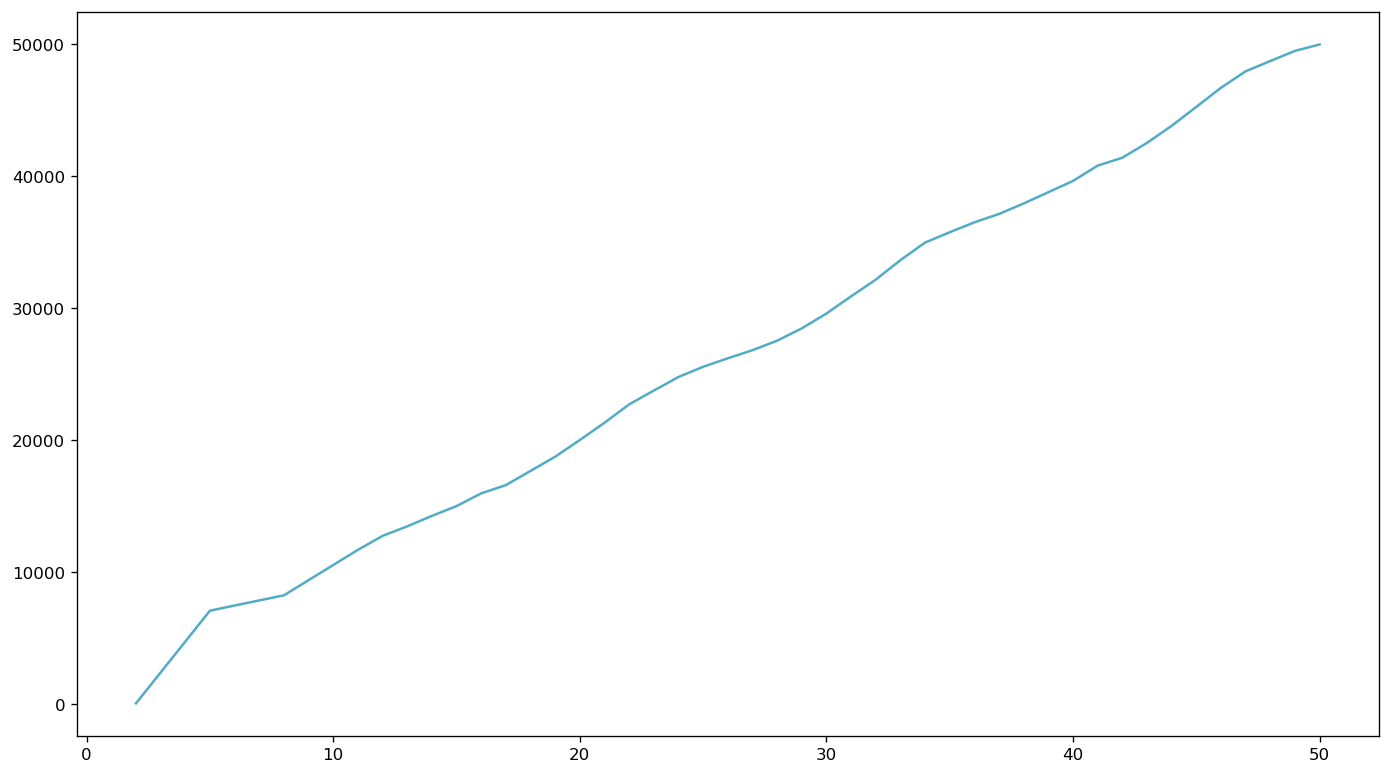

In [31]:
print(df_rec.head())

fig=plt.figure(figsize=(14, 8), dpi= 120, facecolor='w', edgecolor='k')
blues = ["#66D7EB", "#51ACC5", "#3E849E", "#2C5F78", "#1C3D52", "#0E1E2B"]

plt.plot(df_rec.months_since_install, df_rec.reading, color=blues[1], label="REC Production")
ax = plt.subplot()

In [34]:
import statsmodels.api as sm
from statsmodels.api import OLS

x, y = np.arange(len(decomposition.trend.dropna())), decomposition.trend.dropna()
x = sm.add_constant(x)
model = OLS(y, x)
res = model.fit()
print(res.summary())
fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].plot(decomposition.trend.dropna().values, label='trend')
ax[0].plot([res.params.x1*i + res.params.const for i in np.arange(len(decomposition.trend.dropna()))])
ax[1].plot(res.resid.values);
ax[1].plot(np.abs(res.resid.values));
ax[1].hlines(0, 0, len(res.resid), color='r');
ax[0].set_title("Trend and Regression");
ax[1].set_title("Residuals");

NameError: name 'decomposition' is not defined

In [35]:
df_rec.reading[1:]

1      7082
2      8244
3     11689
4     12749
5     13471
6     14267
7     15006
8     15970
9     16597
10    17671
11    18749
12    20015
13    21322
14    22714
15    23763
16    24793
17    25563
18    26208
19    26822
20    27544
21    28477
22    29600
23    30904
24    32169
25    33647
26    34980
27    35761
28    36514
29    37148
30    37941
31    38799
32    39649
33    40814
34    41409
35    42534
36    43826
37    45264
38    46713
39    47960
40    48737
41    49509
42    49993
Name: reading, dtype: int64

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose
#plt.plot(df_rec.months_since_install, df_rec.reading, color=blues[1], label="REC Production")

series = [df_rec.months_since_install, df_rec.reading]
result = seasonal_decompose(series, model='additive')
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None

## Solar Irradiance and Weather Data

In [2]:
conn = sqlite3.connect('solar.db')
cur = conn.cursor()
q = "SELECT * FROM weather"
df_w = pd.read_sql_query(q, conn)
#conn.commit()
conn.close()

In [3]:
df_w.head()

,year,month,day,hour,minute,GHI_w_per_m2,DHI_w_per_m2,DNI_w_per_m2,wind_speed_m_per_s,temp_c,solar_zenith_angle_deg,cloud_type
0,2013,1,1,0,0,0,0,0,0.3,-1.0,160.08,7
1,2013,1,1,0,30,0,0,0,0.3,-1.0,158.45,7
2,2013,1,1,1,0,0,0,0,0.3,-1.0,155.32,7
3,2013,1,1,1,30,0,0,0,0.3,-1.0,151.19,4
4,2013,1,1,2,0,0,0,0,0.4,-2.0,146.45,4


In [57]:
GHI_mean = np.zeros((366,48))  # day by 30 minute increment, averaged over years
DHI_mean = np.zeros((366,48))  # day by 30 minute increment, averaged over years
DNI_mean = np.zeros((366,48))  # day by 30 minute increment, averaged over years

days_per_month = {0:0, 1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

In [62]:


def start_day_index(month):
    start_index = 0
    for m in range(0,month):
        start_index += days_per_month[m]
    return start_index
        

def distill_by_month(month, start_index, GHI_mean, DHI_mean, DNI_mean):
    meas = np.array(range(0,48))
    for day in range(1,days_per_month[month]+1):
        tmp_data = df_w[(df_w['month']==month) & (df_w['day'] == day)]
        for m in meas:  # 1 measurement every 30 minutes, 48 per day
            row = tmp_data[(tmp_data['hour']==int(str(m/2).split('.')[0]))&(tmp_data['minute']==int(str(m/2).split('.')[1])*6)].mean()
            GHI_mean[day+start_index-1, m] = row["GHI_w_per_m2"]
            DHI_mean[day+start_index-1, m] = row["DHI_w_per_m2"]
            DNI_mean[day+start_index-1, m] = row["DNI_w_per_m2"]
    return GHI_mean, DHI_mean, DNI_mean
        

In [63]:
for month in range(1,13):
    start_index = start_day_index(month)
    GHI_mean, DHI_mean, DNI_mean = distill_by_month(month, start_index, GHI_mean, DHI_mean, DNI_mean)

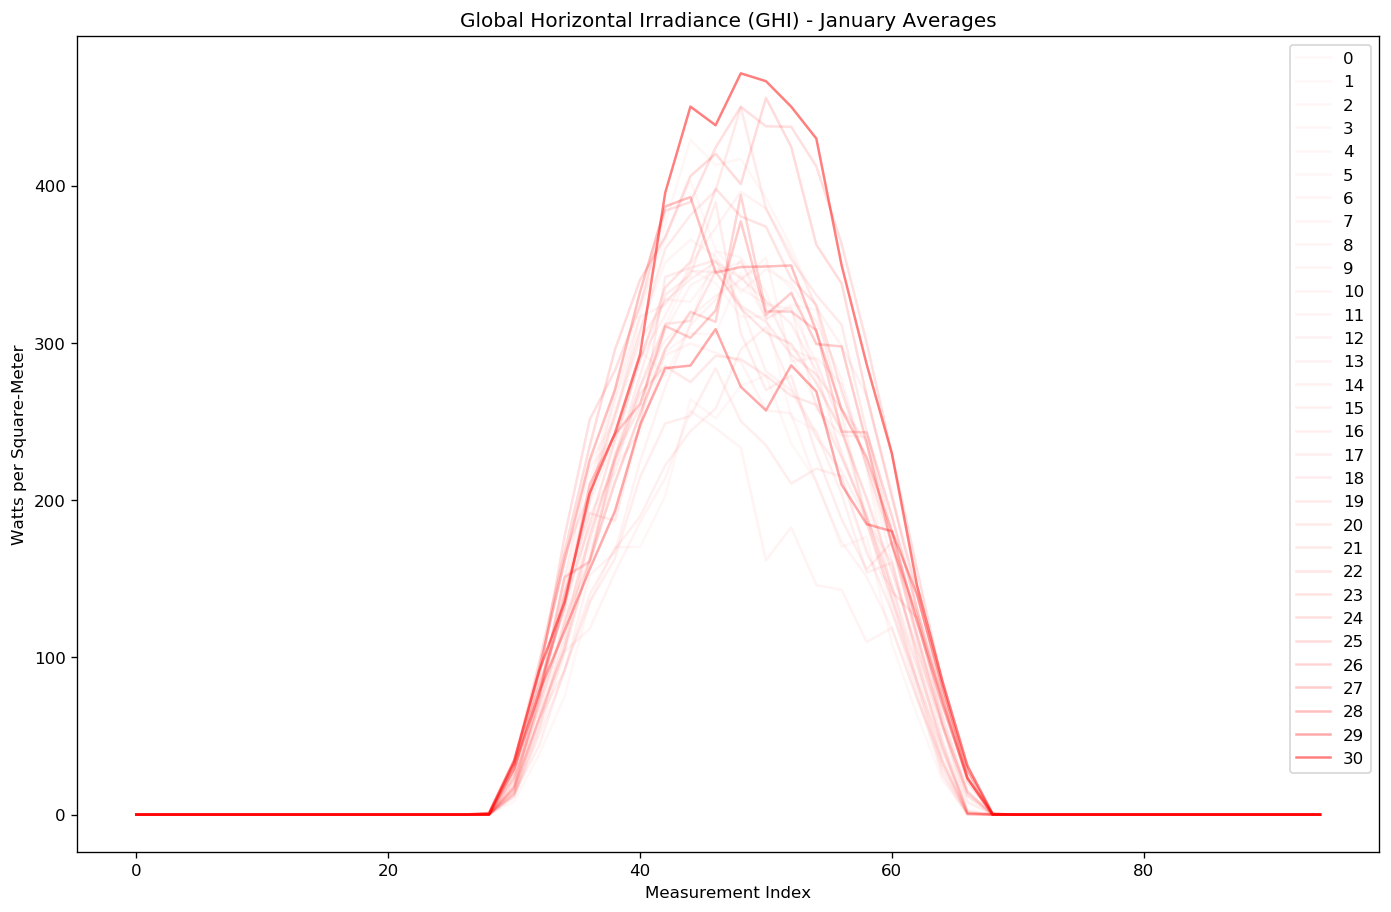

In [64]:
fig=plt.figure(figsize=(14, 9), dpi= 120, facecolor='w', edgecolor='k')
for p in range(0,31):
    plt.plot(meas,GHI_mean[p,:],label=str(p), color="red", alpha=1.0/(32-p))
plt.legend()
plt.title("Global Horizontal Irradiance (GHI) - January Averages")
plt.ylabel("Watts per Square-Meter")
plt.xlabel("Measurement Index")
plt.show()

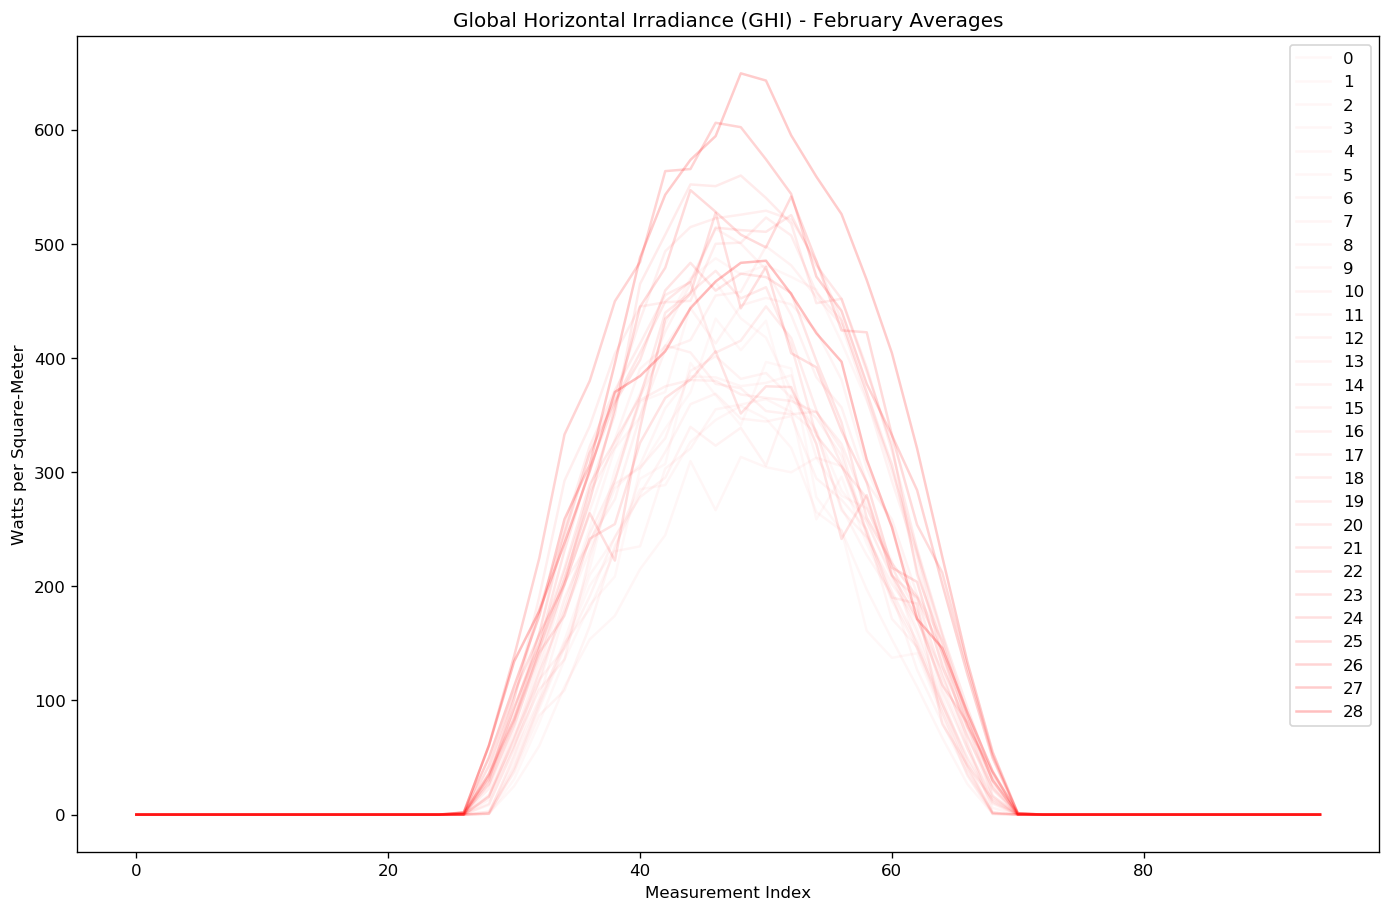

In [65]:
month = 2
fig=plt.figure(figsize=(14, 9), dpi= 120, facecolor='w', edgecolor='k')
for p in range(0,days_per_month[month]+1):
    plt.plot(meas,GHI_mean[start_day_index(month)+p,:],label=str(p), color="red", alpha=1.0/(32-p))
plt.legend()
plt.title("Global Horizontal Irradiance (GHI) - February Averages")
plt.ylabel("Watts per Square-Meter")
plt.xlabel("Measurement Index")
plt.show()

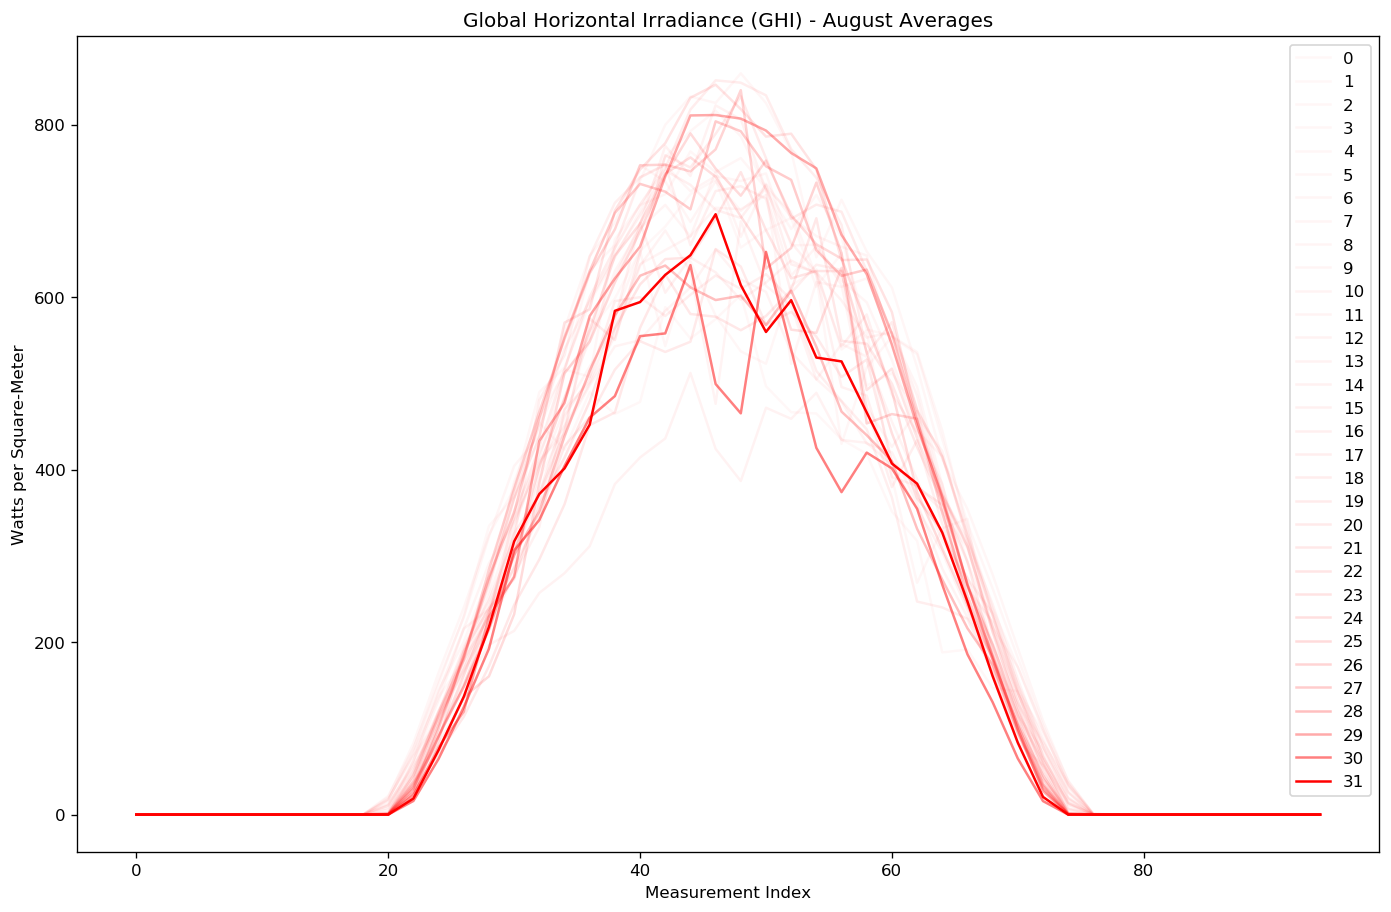

In [67]:
month = 8
fig=plt.figure(figsize=(14, 9), dpi= 120, facecolor='w', edgecolor='k')
for p in range(0,days_per_month[month]+1):
    plt.plot(meas,GHI_mean[start_day_index(month)+p,:],label=str(p), color="red", alpha=1.0/(32-p))
plt.legend()
plt.title("Global Horizontal Irradiance (GHI) - August Averages")
plt.ylabel("Watts per Square-Meter")
plt.xlabel("Measurement Index")
plt.show()

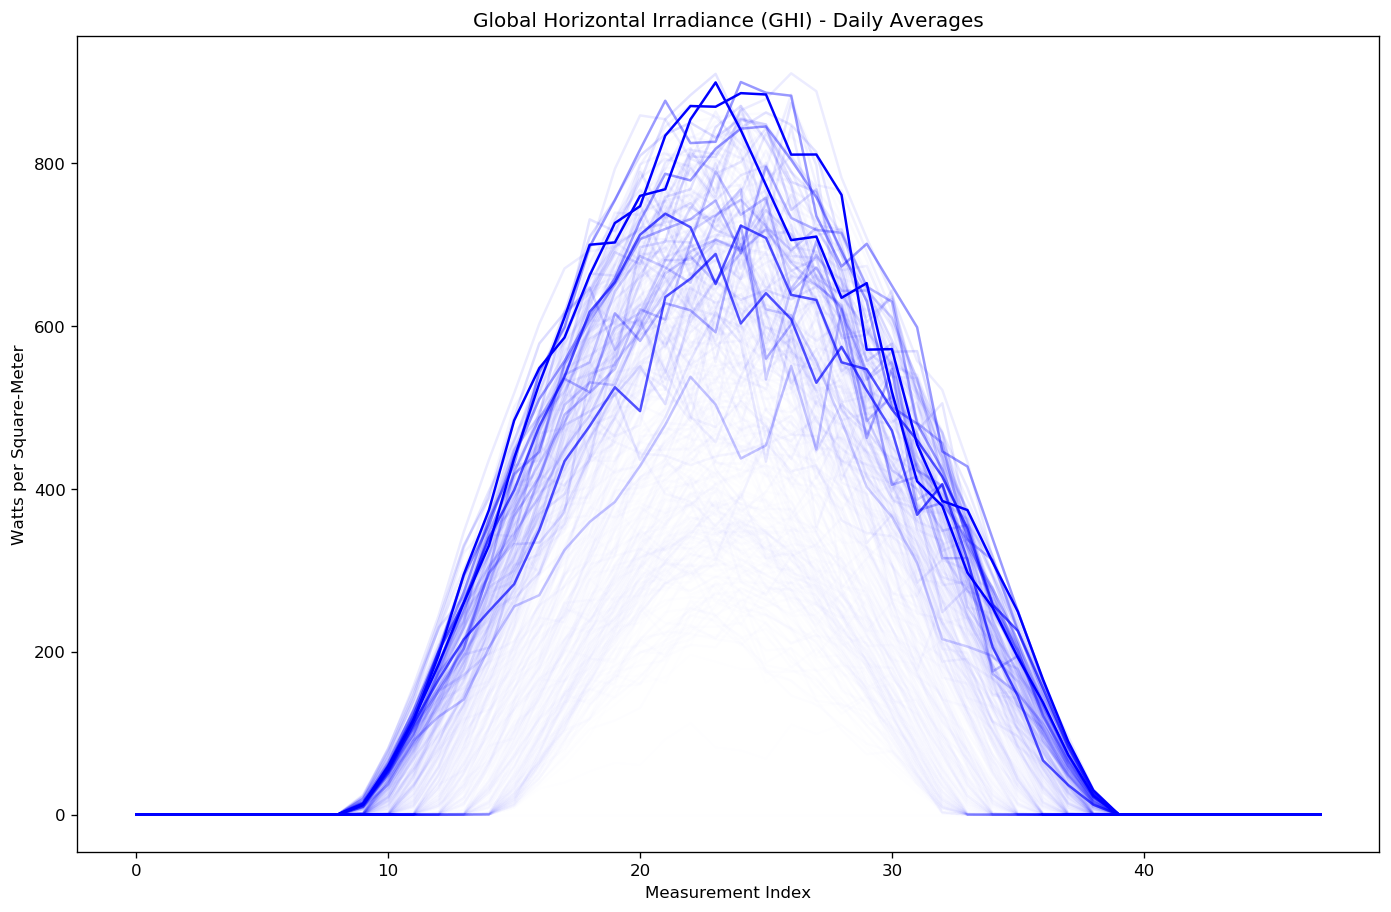

In [75]:
fig=plt.figure(figsize=(14, 9), dpi= 120, facecolor='w', edgecolor='k')
for d in range(0,366):
    plt.plot(meas,GHI_mean[d,:],label=str(d), color="blue", alpha=1.0/(abs(365.0/2-d)))
#plt.legend()
plt.title("Global Horizontal Irradiance (GHI) - Daily Averages")
plt.ylabel("Watts per Square-Meter")
plt.xlabel("Measurement Index")
plt.show()